# Metadata

```yaml
Course:    DS 5001 
Module:    08 Lab
Topic:     LDA Topic Contiguity
Author:    R.C. Alvarado
Date:      09 March 2023
```

**Purpose:** To explore topc contiguity in correlational and informational vector spaces.

# Set Up

## Config

In [1]:
data_in = '../data/output'
data_out = '../data/output'
data_prefix = 'austen-melville'
local_lib = "../lib/"
colors = "YlGnBu"
n_topics = 40
OHCO = ['book_id','chap_num']

## Imports

In [2]:
import pandas as pd
import numpy as np
import plotly_express as px

In [3]:
import sys; sys.path.append(local_lib)
from hac import HAC

# Get the Data

In [4]:
DOCS = pd.read_csv(f"{data_in}/{data_prefix}-LDA_DOCS-chaps.csv").set_index(OHCO)
TOPICS = pd.read_csv(f"{data_in}/{data_prefix}-LDA_TOPICS-{n_topics}.csv").set_index('topic_id')
THETA = pd.read_csv(f"{data_in}/{data_prefix}-LDA_THETA-{n_topics}.csv").set_index(OHCO)
PHI = pd.read_csv(f"{data_in}/{data_prefix}-LDA_PHI-{n_topics}.csv").set_index('topic_id')

In [5]:
LIB = pd.read_csv(f'{data_in}/{data_prefix}-LIB_FIXED.csv').set_index('book_id')

Create a short label for each author for display purposes.

In [6]:
LIB['author_key'] = LIB.author.str.split(', ').str[0].str.lower()

# Topic Correlations

In [83]:
X = pd.concat([THETA.corr(method='kendall').stack().to_frame('corr_theta'), 
               PHI.T.corr(method='kendall').stack().to_frame('corr_phi')], axis=1)
X.index.names = ['topic_id_x','topic_id_y']
X = X.query("topic_id_x < topic_id_y") 
X = X.reset_index()

X['corr_mean'] = (X.corr_theta + X.corr_phi) / 2
X['weight_x'] = X.topic_id_x.map(TOPICS.doc_weight_sum)
X['weight_y'] = X.topic_id_y.map(TOPICS.doc_weight_sum)
X['weight_mean'] = (X.weight_x + X.weight_y) / 2
X['label_x'] = X.topic_id_x.map(TOPICS.label)
X['label_y'] = X.topic_id_y.map(TOPICS.label)

X = X.set_index(['topic_id_x','topic_id_y'])

In [84]:
X.sort_values('corr_mean', ascending=False)[['corr_mean','label_x','label_y']].head(20).style.background_gradient(cmap=colors)

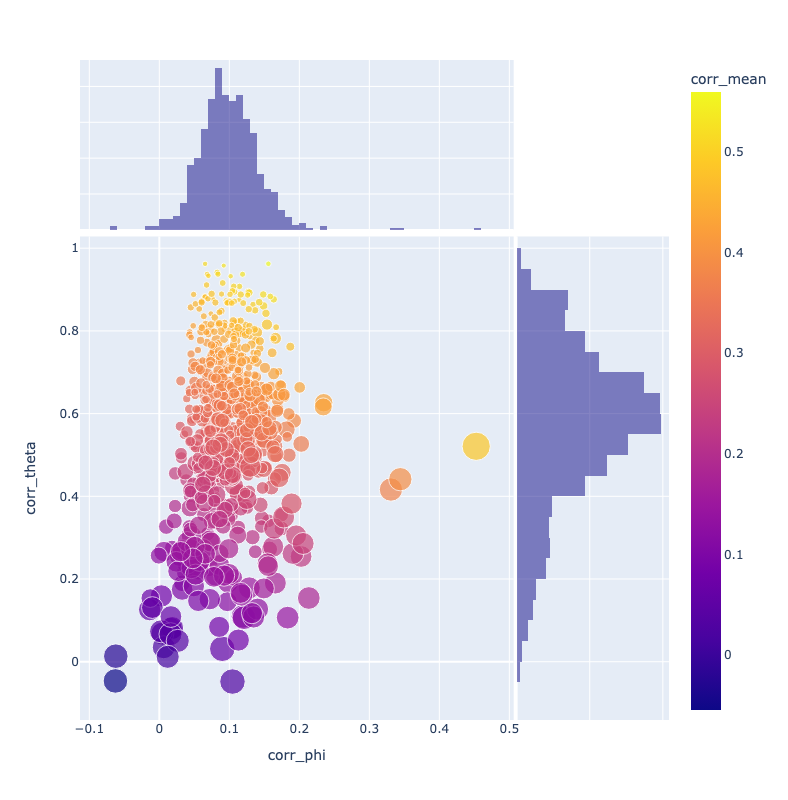

In [85]:
px.scatter(X.reset_index(), 'corr_phi', 'corr_theta', 
           hover_data=['label_x','label_y'],
           size='weight_mean', 
           color='corr_mean', marginal_x='histogram', marginal_y='histogram',
           height=800, width=1000, 
           log_x=False, log_y=False)

# Mutual Information
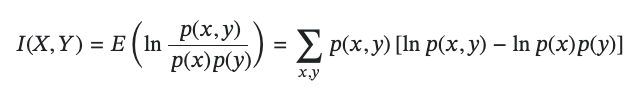

In [86]:
weight_thresh = .2

In [87]:
THETA2 = THETA[THETA >= weight_thresh].stack().to_frame('topic_weight').rename_axis(['book_id','chap_num','topic_id']).reset_index()
TOPICS['p'] = THETA2.topic_id.value_counts(normalize=True)

In [88]:
TPAIRS = THETA2.merge(THETA2, on=OHCO).value_counts(['topic_id_x', 'topic_id_y']).to_frame('n').query("topic_id_x < topic_id_y")
TPAIRS = TPAIRS.sort_index().reset_index()

TPAIRS['p_xy'] = TPAIRS.n / TPAIRS.n.sum()
TPAIRS['p_x'] = TPAIRS.topic_id_x.map(TOPICS.p)
TPAIRS['p_y'] = TPAIRS.topic_id_y.map(TOPICS.p)
TPAIRS['p_yGx'] = TPAIRS.p_xy / TPAIRS.p_x
TPAIRS['p_xGy'] = TPAIRS.p_xy / TPAIRS.p_y
TPAIRS['pwmi'] = np.log2(TPAIRS.p_xy / (TPAIRS.p_x * TPAIRS.p_y))
TPAIRS['mi'] = TPAIRS.pwmi * TPAIRS.p_xy
TPAIRS['nmi'] = TPAIRS.pwmi / np.log2(1/TPAIRS.p_xy) # Normalized point-wise mutual information (Bouma 2009) https://svn.spraakdata.gu.se/repos/gerlof/pub/www/Docs/npmi-pfd.pdf 

TPAIRS = TPAIRS.set_index(['topic_id_x', 'topic_id_y'])
TPAIRS = TPAIRS.join(X)

In [89]:
TPAIRS.sort_values('nmi', ascending=False).head() #.style.background_gradient(cmap=colors)

n      p_xy       p_x       p_y     p_yGx     p_xGy  \
topic_id_x topic_id_y                                                          
T20        T38         154  0.177215  0.121665  0.135539  1.456584  1.307485   
T29        T34          28  0.032221  0.024546  0.082711  1.312653  0.389562   
T05        T20          44  0.050633  0.041089  0.121665  1.232287  0.416167   
           T38          41  0.047181  0.041089  0.135539  1.148267  0.348097   
T07        T10          12  0.013809  0.016009  0.049093  0.862601  0.281283   

                           pwmi        mi       nmi  corr_theta  corr_phi  \
topic_id_x topic_id_y                                                       
T20        T38         3.425810  0.607106  1.372286    0.520970  0.452628   
T29        T34         3.988267  0.128506  0.804758    0.616180  0.234195   
T05        T20         3.340353  0.169132  0.776144    0.416320  0.330843   
           T38         3.082679  0.145443  0.699709    0.441393  0.344296   
T07        T10         4.135108  0.057102  0.669301    0.548092  0.117200   

                       corr_mean    weight_x    weight_y  weight_mean  \
topic_id_x topic_id_y                                                   
T20        T38          0.486799  126.611068  126.849768   126.730418   
T29        T34          0.425187   23.457972   79.256877    51.357424   
T05        T20          0.373581   45.796196  126.611068    86.203632   
           T38          0.392844   45.796196  126.849768    86.322982   
T07        T10          0.332646   21.689520   51.542008    36.615764   

                                                                 label_x  \
topic_id_x topic_id_y                                                      
T20        T38         T20 time, feelings, heart, mind, moment, lette...   
T29        T34         T29 man, men, war, gun, guns, deck, jacket, ma...   
T05        T20         T05 father, mother, family, years, brother, ti...   
           T38         T05 father, mother, family, years, brother, ti...   
T07        T10         T07 doctor, day, country, village, horse, morn...   

                                                                 label_y  
topic_id_x topic_id_y                                                     
T20        T38         T38 time, day, house, thing, room, sister, man...  
T29        T34         T34 man, deck, men, ship, sailors, time, capta...  
T05        T20         T20 time, feelings, heart, mind, moment, lette...  
           T38         T38 time, day, house, thing, room, sister, man...  
T07        T10         T10 valley, natives, time, island, house, plac...

In [90]:
TPAIRS.describe().T

,count,mean,std,min,25%,50%,75%,max
n,221.0,3.932127,11.466945,1.000000,1.000000,1.000000,3.000000,154.000000
p_xy,221.0,0.004525,0.013196,0.001151,0.001151,0.001151,0.003452,0.177215
p_x,221.0,0.030049,0.023545,0.002134,0.016009,0.027748,0.039488,0.121665
p_y,221.0,0.041364,0.038064,0.002134,0.011206,0.025614,0.068303,0.135539
p_yGx,221.0,0.174523,0.232498,0.009458,0.046880,0.089854,0.215650,1.456584
p_xGy,221.0,0.141807,0.149165,0.008490,0.044927,0.098023,0.196046,1.307485
pwmi,221.0,1.942321,1.458802,-2.375854,1.184558,2.077319,3.026402,5.980598
mi,221.0,0.011895,0.044978,-0.005257,0.001727,0.003558,0.008104,0.607106
nmi,221.0,0.238595,0.198671,-0.260659,0.130788,0.241200,0.349539,1.372286
corr_theta,221.0,0.496958,0.154702,-0.047978,0.421536,0.516462,0.606712,0.815294


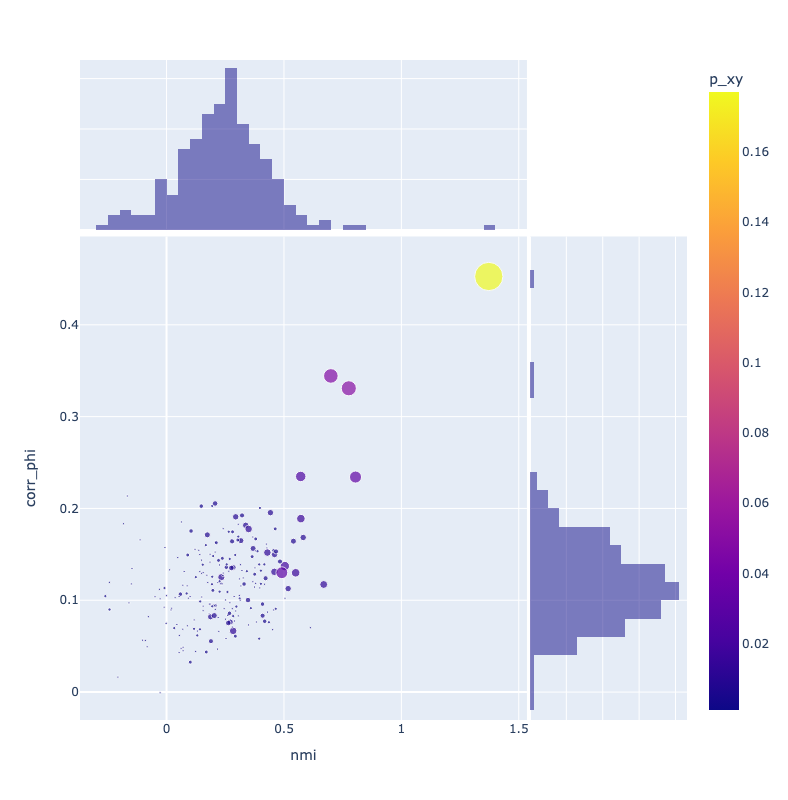

In [91]:
px.scatter(TPAIRS.reset_index(), 'nmi', 'corr_phi', 
           hover_data=['label_x','label_y'],
           size='n', 
           color='p_xy', marginal_x='histogram', marginal_y='histogram',
           height=800, width=1000, 
           log_x=False, log_y=False)

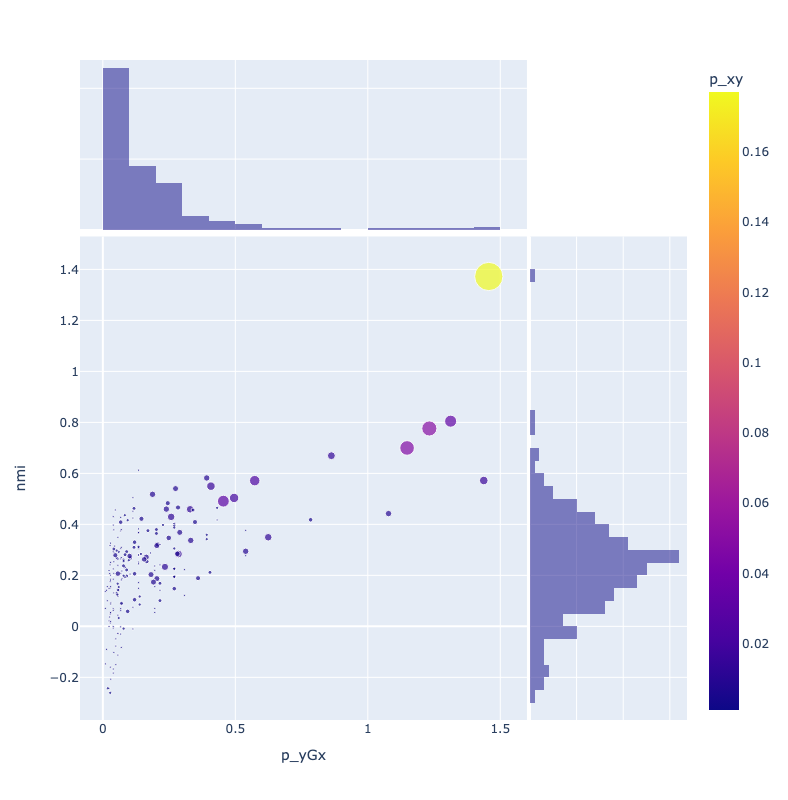

In [93]:
px.scatter(TPAIRS.reset_index(), 'p_yGx', 'nmi', 
           hover_data=['label_x','label_y'],
           size='n', 
           color='p_xy', marginal_x='histogram', marginal_y='histogram',
           height=800, width=1000, 
           log_x=False, log_y=False)

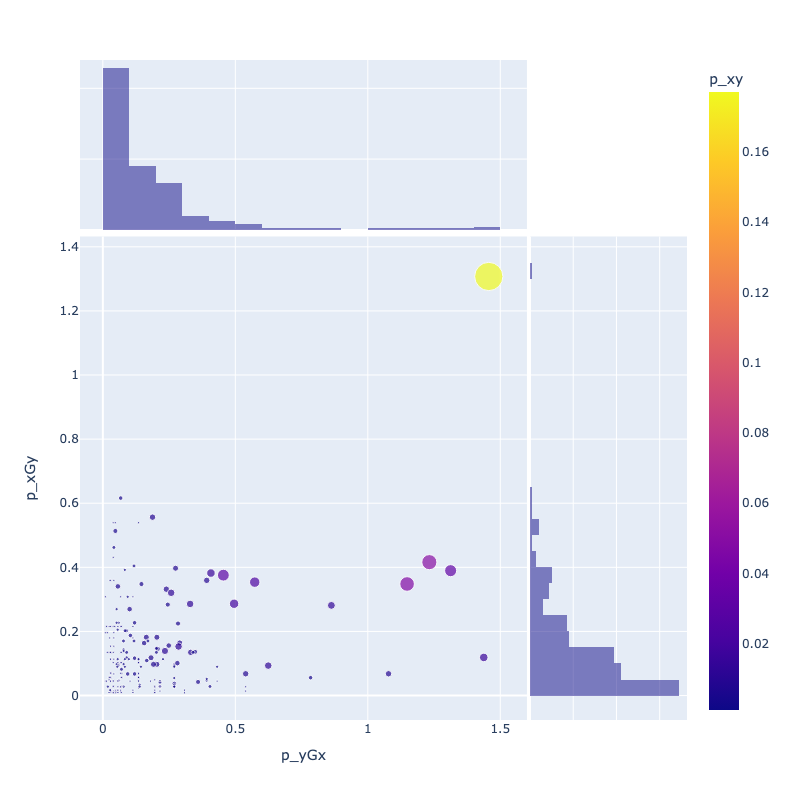

In [94]:
px.scatter(TPAIRS.reset_index(), 'p_yGx', 'p_xGy', 
           hover_data=['label_x','label_y'],
           size='n', 
           color='p_xy', marginal_x='histogram', marginal_y='histogram',
           height=800, width=1000, 
           log_x=False, log_y=False)

# Graph

In [95]:
from graphviz import Graph

In [97]:
TOPICS['short_label'] = TOPICS.label.apply(lambda x: x.split()[0] + r"\n" + " ".join(x.split(", ")[1:4]) + r"\n" + " ".join(x.split(", ")[4:8]) )

In [112]:
corr_thresh = .2
nmi_thresh = .25

In [113]:
EDGES = []

# By correlation
EDGES.append(TPAIRS[TPAIRS.corr_phi > corr_thresh].index.to_list())

# By mutual information
EDGES.append(TPAIRS[TPAIRS.nmi > nmi_thresh].index.to_list())

# By both
EDGES.append(TPAIRS[(TPAIRS.corr_phi > corr_thresh) & (TPAIRS.nmi > nmi_thresh)].index.to_list())

In [127]:
G = Graph('tm', node_attr={'shape':'rect'})

edge_num = 1
NODES = set()
for src, dst in EDGES[edge_num]:
    NODES.add(src)
    NODES.add(dst)
    G.edge(src, dst)

for node in sorted(NODES):
    G.node(node, TOPICS.loc[node].short_label)

In [128]:
G.view(f"tm{edge_num}")

'tm1.pdf'

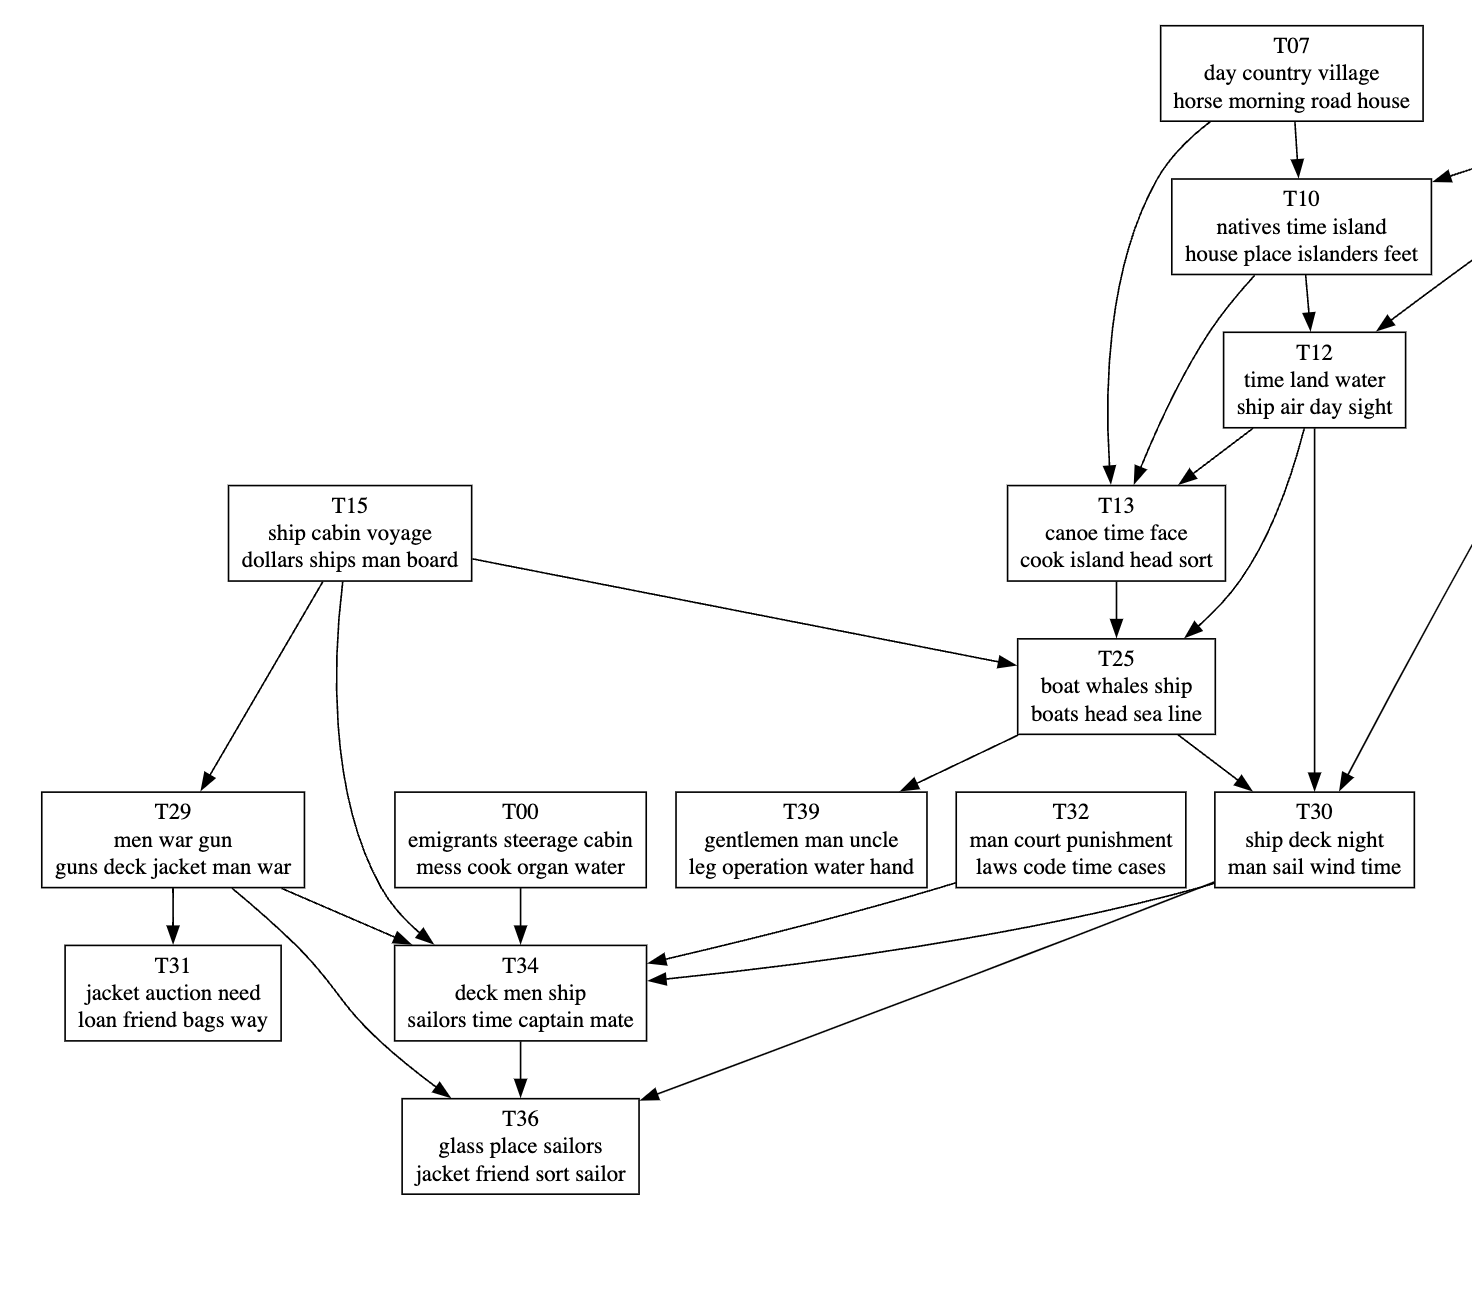

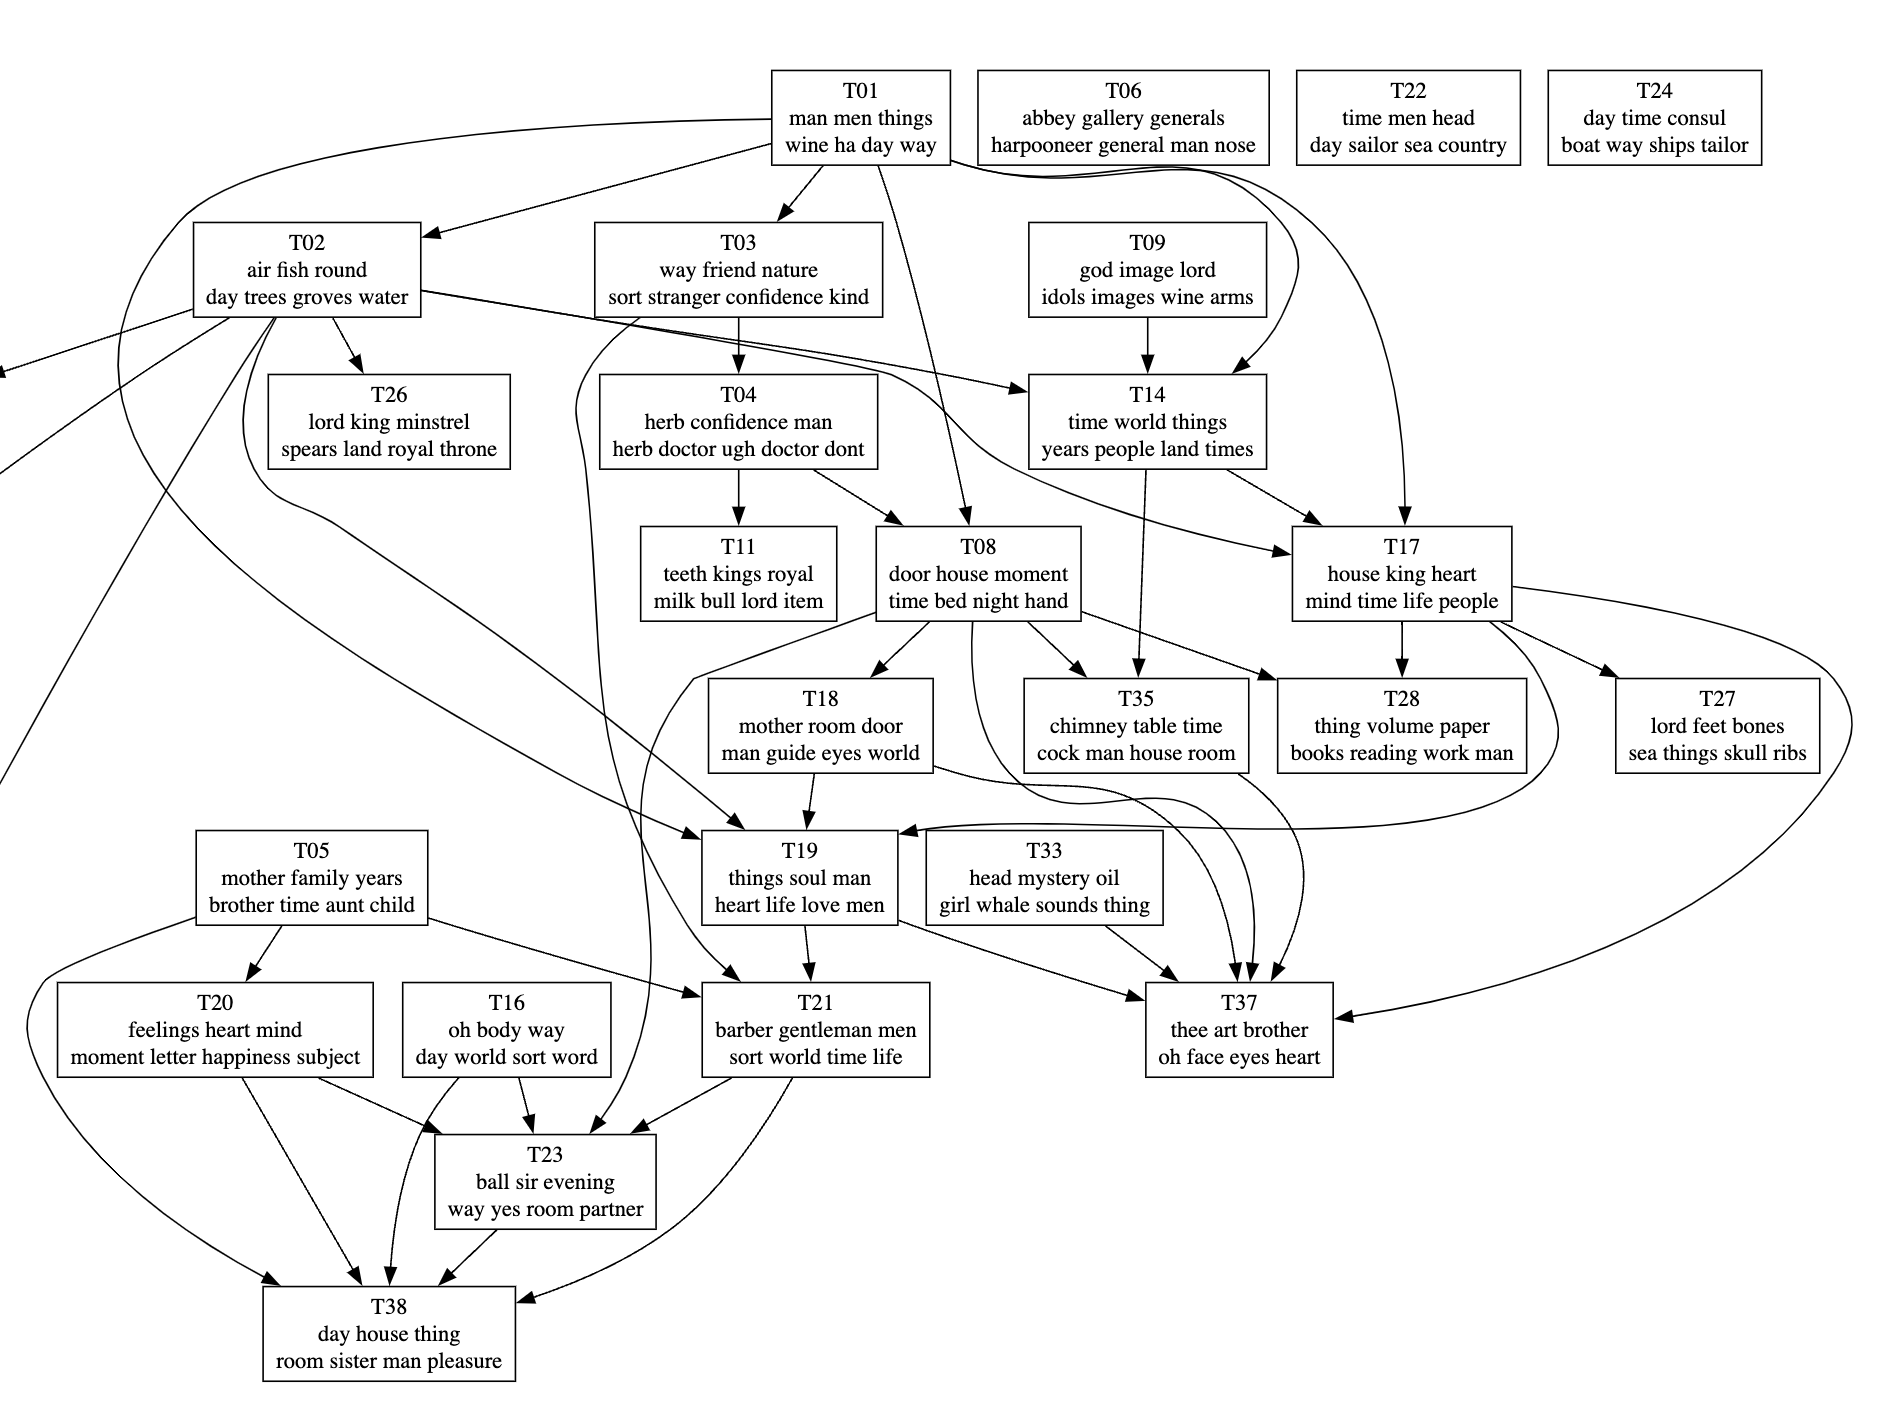